In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.metrics import make_scorer
import shap
from sklearn.feature_selection import RFECV

In [4]:
data = pd.read_csv("creat_classified.csv") #insert path of dataset here

In [5]:
df = data.copy()

Features selected in this model:

1. Race
2. Sex
3. Age
4. Procedure type
5. BMI
6. Hypertension
7. Diabetes
8. Social History
9. Pre-op GFR


1. Linear Model

In [6]:
# Classify features into categorical, continuous and binary
features = ['cleaned_race',  'sex_ind', 'age', 'bmi', 'pre_creat', 'pn_ind', 'htn_ind', 'diab_ind', 'tob_all']
cat_features = ['cleaned_race']
cont_features = ['age', 'bmi' ,'pre_creat']
bin_features = ['pn_ind', 'htn_ind', 'diab_ind', 'tob_all', 'sex_ind']
target_col = 'post_creat'

In [7]:
df.dropna(inplace = True)
X = df[features]
y = df[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=cat_features, prefix='race', drop_first = True)

# Standardize continuous features
scaler = StandardScaler()
X[cont_features] = scaler.fit_transform(X[cont_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# MAPE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error: 1.277817462492061
R-squared: 0.5143300853077825
Mean Absolute Percentage Error (MAPE): 26.68%


2. XGBoost Model

In [8]:
df = data.copy()

In [9]:

X = df[features]
y = df[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=cat_features, prefix='race', drop_first = True)

# Standardize continuous features
scaler = StandardScaler()
X[cont_features] = scaler.fit_transform(X[cont_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

# Define hyperparameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.6, 0.8],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'alpha': [1, 5, 10],
    'n_estimators': [10, 50, 100]
}

# Grid search using MSE
grid_search = GridSearchCV(xg_reg, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xg_reg = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_xg_reg.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Mean Squared Error: 0.8399884945776213
Mean Absolute Percentage Error (MAPE): 25.33%
Best Hyperparameters: {'alpha': 5, 'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


SHAP Scores

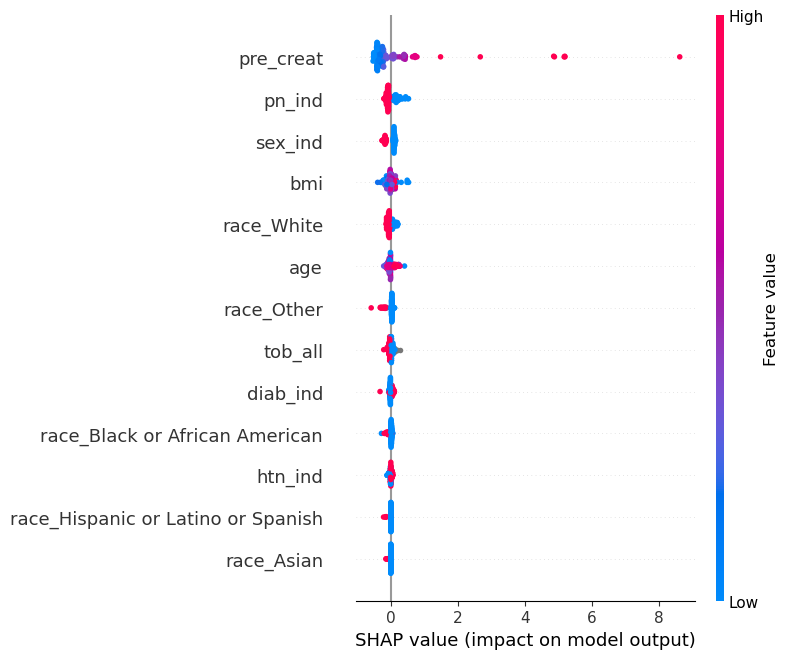

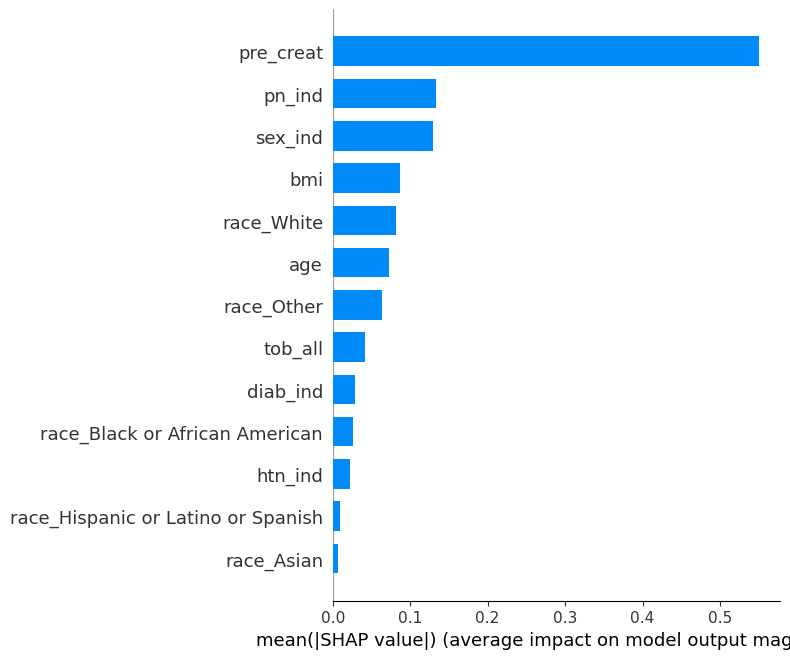

In [10]:
df = data.copy()
df.dropna(subset=target_col, inplace=True)
X = df[features]
y = df[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=cat_features, prefix='race', drop_first = True)

# Standardize continuous features
scaler = StandardScaler()
X[cont_features] = scaler.fit_transform(X[cont_features])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set your optimal hyperparameters
optimal_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.2,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'n_estimators': 100
}


xg_reg = xgb.XGBRegressor(**optimal_params, seed=42)
xg_reg.fit(X_train, y_train)

explainer = shap.Explainer(xg_reg)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar')

Recursive Feature Elimination

Optimal number of features: 7


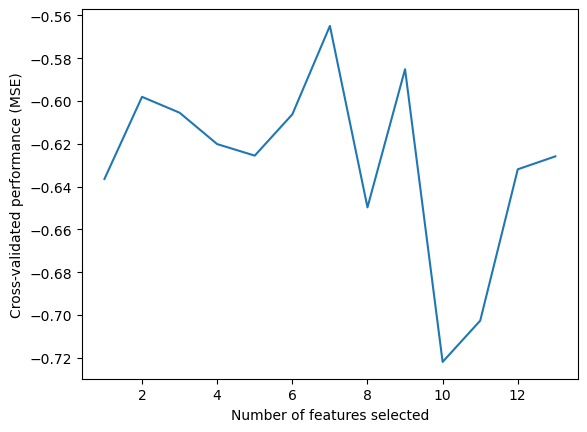

Mean Squared Error on the test set: 0.8640
Mean Absolute Percentage Error (MAPE): 19.81%
Selected features are: Index(['sex_ind', 'age', 'bmi', 'pre_creat', 'pn_ind', 'htn_ind',
       'race_White'],
      dtype='object')


In [11]:
df = data.copy()
df.dropna(subset=target_col, inplace=True)
X = df[features]
y = df[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=cat_features, prefix='race', drop_first = True)

# Standardize continuous features
scaler = StandardScaler()
X[cont_features] = scaler.fit_transform(X[cont_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set your optimal hyperparameters
optimal_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.2,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.3,
    'n_estimators': 100
}


xg_reg = xgb.XGBRegressor(**optimal_params, seed=42)
xg_reg.fit(X_train, y_train)


explainer = shap.Explainer(xg_reg)
shap_values = explainer.shap_values(X_test)

rfecv = RFECV(estimator=xg_reg, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validated performance (MSE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Train a new XGBoost model with the selected features
xg_reg_selected = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xg_reg_selected.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set
y_pred = xg_reg_selected.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on the test set: {:.4f}".format(mse))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print("Selected features are:", selected_features)

GRID search + RFE

Optimal number of features: 2


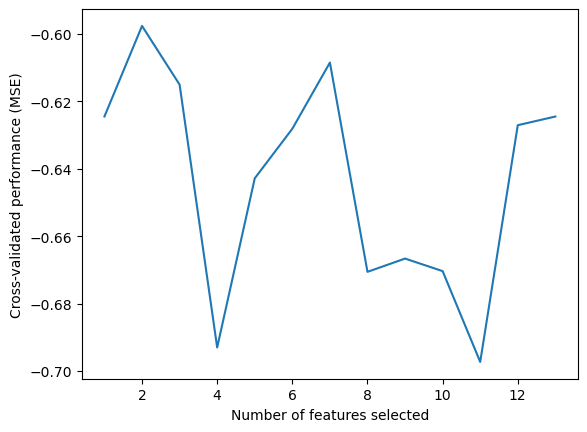

Mean Squared Error on the test set: 0.8694
Mean Absolute Percentage Error (MAPE): 19.67%
Selected features are: Index(['pre_creat', 'pn_ind'], dtype='object')


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

# Load data and handle missing values
df = data.copy()
df.dropna(subset=target_col, inplace=True)
X = df[features]
y = df[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=cat_features, prefix='race', drop_first=True)

# Standardize continuous features
scaler = StandardScaler()
X[cont_features] = scaler.fit_transform(X[cont_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set your hyperparameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.6, 0.8],
    'n_estimators': [10, 50, 100]
}

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Create GridSearchCV object
grid_search = GridSearchCV(xg_reg, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xg_reg = grid_search.best_estimator_

# Perform RFE using the best model
rfecv = RFECV(estimator=best_xg_reg, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

# Plot the cross-validated performance
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validated performance (MSE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Train a new XGBoost model with the selected features
xg_reg_selected = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xg_reg_selected.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set
y_pred = xg_reg_selected.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on the test set: {:.4f}".format(mse))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print("Selected features are:", selected_features)


In [13]:
df.describe()

,Unnamed: 0,age,sex_ind,pre_creat,post_creat,bmi,tob_all,htn_ind,diab_ind,American Indian or Native,...,Other,White,white_ind,pn_ind,American Indian or Native.1,Asian.1,Black or African American.1,Hispanic or Latino or Spanish.1,Other.1,White.1
count,840.000000,840.000000,840.000000,840.000000,840.000000,796.000000,793.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,467.585714,61.892857,0.365476,1.384536,1.547190,29.337588,0.446406,0.629762,0.263095,0.003571,...,0.120238,0.672619,0.672619,0.659524,0.003571,0.028571,0.146429,0.028571,0.120238,0.672619
std,274.136368,12.745438,0.481850,1.734187,1.602449,6.151360,0.497433,0.483156,0.440576,0.059690,...,0.325434,0.469537,0.469537,0.474152,0.059690,0.166698,0.353746,0.166698,0.325434,0.469537
min,0.000000,18.000000,0.000000,0.430000,0.540000,16.900000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,55.000000,0.000000,0.820000,0.920000,24.957500,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,471.500000,64.000000,0.000000,0.980000,1.180000,28.600000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,707.250000,71.000000,1.000000,1.220000,1.490000,32.457500,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,941.000000,89.000000,1.000000,19.640000,15.450000,56.550000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Race/ Demographic Analyses

In [14]:
df.cleaned_race.value_counts()

White                            565
Black or African American        123
Other                            101
Hispanic or Latino or Spanish     24
Asian                             24
American Indian or Native          3
Name: cleaned_race, dtype: int64

In [15]:
df = data.copy()
df.dropna(subset=target_col, inplace=True)
X = df[features]
grouped_by_race = X.groupby('cleaned_race')
print(grouped_by_race.value_counts())

cleaned_race               sex_ind  age  bmi    pre_creat  pn_ind  htn_ind  diab_ind  tob_all
American Indian or Native  1        60   43.10  1.10       1.0     1.0      1.0       1.0        1
Asian                      0        33   26.35  9.33       0.0     1.0      0.0       0.0        1
                                    74   24.47  1.19       1.0     1.0      1.0       1.0        1
                                    39   38.37  1.16       1.0     1.0      1.0       0.0        1
                                    46   17.90  0.62       0.0     0.0      0.0       0.0        1
                                                                                                ..
White                      0        43   23.15  0.93       1.0     0.0      0.0       1.0        1
                                    44   24.41  1.17       1.0     0.0      0.0       1.0        1
                                         31.27  0.89       1.0     1.0      0.0       1.0        1
               

WHITE

In [16]:
df_white = df[df['cleaned_race'] == 'White']

C:\Users\cc4865\AppData\Local\Temp\ipykernel_8068\1363149858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_white.dropna(subset=target_col, inplace=True)


Optimal number of features: 7


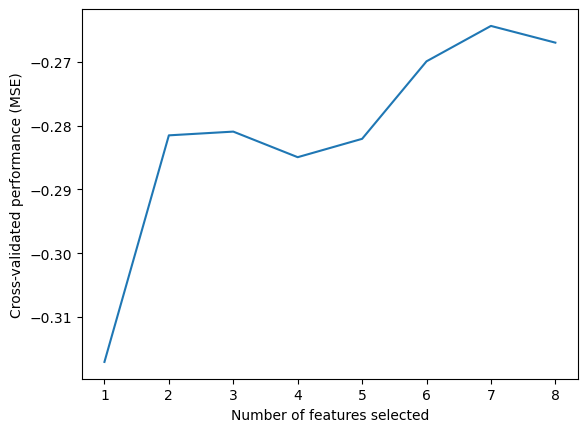

Mean Squared Error on the test set: 0.2269
Mean Absolute Percentage Error (MAPE): 20.15%
Selected features are: Index(['sex_ind', 'age', 'pre_creat', 'pn_ind', 'htn_ind', 'diab_ind',
       'tob_all'],
      dtype='object')


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

# Load data and handle missing values
df = data.copy()
df_white = df[df['cleaned_race'] == 'White']
df_white.dropna(subset=target_col, inplace=True)
X = df_white[features]
y = df_white[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=cat_features, prefix='race', drop_first=True)

# Standardize continuous features
scaler = StandardScaler()
X[cont_features] = scaler.fit_transform(X[cont_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set your hyperparameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.6, 0.8],
    'n_estimators': [10, 50, 100]
}

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Create GridSearchCV object
grid_search = GridSearchCV(xg_reg, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xg_reg = grid_search.best_estimator_

# Perform RFE using the best model
rfecv = RFECV(estimator=best_xg_reg, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

# Plot the cross-validated performance
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validated performance (MSE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Train a new XGBoost model with the selected features
xg_reg_selected = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xg_reg_selected.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set
y_pred = xg_reg_selected.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on the test set: {:.4f}".format(mse))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print("Selected features are:", selected_features)


POC

In [18]:
df_poc = df[df['cleaned_race'] != 'White']

C:\Users\cc4865\AppData\Local\Temp\ipykernel_8068\918208882.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_poc.dropna(subset=target_col, inplace=True)


Optimal number of features: 12


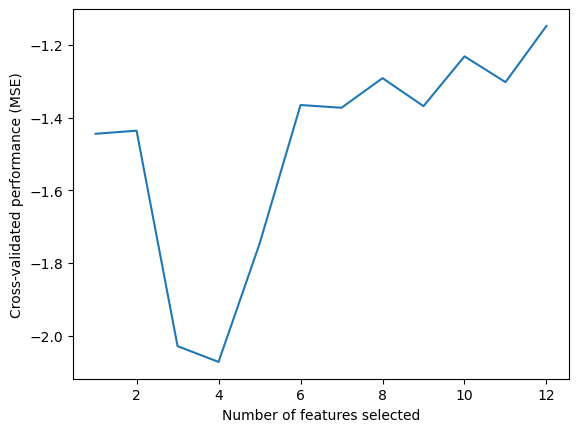

Mean Squared Error on the test set: 0.9837
Mean Absolute Percentage Error (MAPE): 20.06%
Selected features are: Index(['sex_ind', 'age', 'bmi', 'pre_creat', 'pn_ind', 'htn_ind', 'diab_ind',
       'tob_all', 'race_Asian', 'race_Black or African American',
       'race_Hispanic or Latino or Spanish', 'race_Other'],
      dtype='object')


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

# Load data and handle missing values
df = data.copy()
df_poc = df[df['cleaned_race'] != 'White']
df_poc.dropna(subset=target_col, inplace=True)
X = df_poc[features]
y = df_poc[target_col]

# One-hot encode categorical features
X = pd.get_dummies(X, columns=cat_features, prefix='race', drop_first=True)

# Standardize continuous features
scaler = StandardScaler()
X[cont_features] = scaler.fit_transform(X[cont_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set your hyperparameter grid for grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.3, 0.6, 0.8],
    'n_estimators': [10, 50, 100]
}

# Initialize XGBoost regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

# Create GridSearchCV object
grid_search = GridSearchCV(xg_reg, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_xg_reg = grid_search.best_estimator_

# Perform RFE using the best model
rfecv = RFECV(estimator=best_xg_reg, step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print("Optimal number of features: {}".format(rfecv.n_features_))

# Plot the cross-validated performance
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validated performance (MSE)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Train a new XGBoost model with the selected features
xg_reg_selected = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
xg_reg_selected.fit(X_train[selected_features], y_train)

# Evaluate the model on the test set
y_pred = xg_reg_selected.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on the test set: {:.4f}".format(mse))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print("Selected features are:", selected_features)
